<img src="https://global.utsa.edu/tec-partnership/images/logos/logotipo-horizontal-azul-transparente.png"  width="600">

## **Actividad 5 | Actividad de visualización de resultados**
### **Análisis de grandes volúmenes de datos (Gpo 10)**
#### Tecnológico de Monterrey
---
*   NOMBRE: Paulina Escalante Campbell
*   MATRÍCULA: A01191962
---
### **Objetivo**
Mostrar los resultados obtenidos a partir de la aplicación de un proceso de entrenamiento de modelos de aprendizaje máquina en grandes volúmenes de datos, mediante el uso de herramientas de visualización como gráficas de dispersión, de tendencia central, mapas de calor y curvas ROC.

#### **Imports**


In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, sum, when, split, col, lit, max, min, expr
from pyspark.sql.functions import to_date, var_samp, variance, var_pop, month, to_timestamp, dayofweek
from pyspark.sql.functions import hour, month
from pyspark.sql.types import NumericType, IntegerType, FloatType
from pyspark.sql.functions import col, round, concat_ws, desc, when, concat
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

from datetime import datetime

# Imports adicionales necesarios
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when, count as spark_count
import numpy as np

# Visualización avanzada - siguiendo metodologías de la Sesión 5
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import altair as alt

# Configurar estilos de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### **1. Definir un proceso de validación cruzada**

Para ello y partiendo de la muestra M = {Mi: Mi es una partición derivada de las variables de caracterización de la población} construida en el paso 1 de la actividad 4 del Módulo 5, se debe de determinar un valor “k” para el proceso de validación cruzada “k-fold” a implementar. Este valor deberá de ser argumentado con profundidad, de tal forma que se garantice que cada uno de los “k-fold” generados, sean muestras representativas de la población.

In [2]:
spark = SparkSession.builder \
    .appName("Maestria_evidencia1") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.default.parallelism", "16") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Mejores tablas
spark.sparkContext.setLogLevel("ERROR") # Quitar warnings innecesarios de Jupyter
#spark, comentando el comando del environment para reducir el ruido del notebook

25/06/17 23:59:31 WARN Utils: Your hostname, Paulinas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.241 instead (on interface en0)
25/06/17 23:59:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/17 23:59:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/17 23:59:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

####
#### La base de datos ha sido limpiada y modificada a este punto
#### 
####
file_path = "/Users/pauescalante/Documents/Maestria/Trimestre 7/BigData/big-data-act/DataModified/expanded_database_ecommerce"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Mostrar cuantos registros se tienen inicialmete para en el futuro reducir a una dimensión contenida
initial_total_count = df.count()
print(f"Número total de registros: {initial_total_count}")

[Stage 3:================================================>     (130 + 13) / 146]

Número total de registros: 109950731


In [8]:
# Imprimiendo el esquema del Dataframe
df.printSchema()

root
 |-- event_time: date (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- event_time_ts: timestamp (nullable = true)
 |-- parent_category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- price_bucket: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- is_weekend: boolean (nullable = true)



In [9]:
# Mostrar el primer registro de ejemplo para visualizar las columnas
df.show(n=1,truncate=False, vertical=True)

-RECORD 0-----------------------------------------------
 event_time      | 2019-11-17                           
 event_type      | view                                 
 product_id      | 5300440                              
 category_id     | 2053013563173241677                  
 brand           | vitek                                
 price           | 17.76                                
 user_id         | 513341639                            
 user_session    | d9544029-2739-4d16-9cac-79650460d9f0 
 event_time_ts   | 2019-11-17 05:35:32                  
 parent_category | None                                 
 subcategory     | None                                 
 price_bucket    | low                                  
 day_of_week     | 1                                    
 is_weekend      | true                                 
only showing top 1 row



In [10]:
# En este punto en actividades previas se limpiaron los datos
# Pero haremos una última limpieza para verificar

#Se eliminan registros con valores nulos
df_clean = df.dropna()

#Se eliminan columnas con valores nulos
df_clean = df_clean.na.drop()

#Se eliminan registros duplicados
df_clean = df_clean.dropDuplicates()
df = df_clean

#### **Variables de categorízación definidas en actividades previas**

EVENT_TYPE:
   - Categorías: view, cart, purchase
   - Distribución: Altamente desbalanceada (~98.5% no-purchase)
   - Implicación: Clase minoritaria requiere cuidado especial

PRICE_BUCKET:
   - Categorías: low, medium, high  
   - Distribución: Relativamente balanceada (~33% cada una)
   - Implicación: Facilita estratificación

COMBINACIÓN (STRATUM):
   - Total estratos: 9 posibles (3 x 3)
   - Distribución: Variable según intersección de categorías
   - Implicación: Necesidad de suficientes muestras por estrato

In [11]:
# Aplicar muestreo inicial para hacer el análisis manejable
# Se han explorado SRS y stratified pero SRS ha sido suficiente para los datos dada su distribución de las variables categóricas
sample_df = df.sample(fraction=0.00001, seed=42)  # 0.001% para análisis inicial
print(f"Muestra para análisis: {sample_df.count():,} registros")

[Stage 9:===================================================>       (7 + 1) / 8]

Muestra para análisis: 1,053 registros


In [8]:
# Variables de caracterización: event_type y price_bucket
sample_df_base = sample_df
sample_df_with_stratum = sample_df_base.withColumn("stratum", 
                                                   concat(sample_df_base["event_type"], 
                                                         lit("_"), 
                                                         sample_df_base["price_bucket"])).cache()

# Muestreo estratificado
target_sample_size = 5000
total_count = sample_df_with_stratum.count()

strata_counts = sample_df_with_stratum.groupBy("stratum").count().collect()
fractions = {}
for row in strata_counts:
    stratum = row["stratum"]
    count = row["count"]
    proportion = count / total_count
    target_stratum_size = target_sample_size * proportion
    sampling_fraction = target_stratum_size / count
    fractions[stratum] = sampling_fraction if sampling_fraction <= 1.0 else 1.0

# Generar muestra estratificada final
sample_df = sample_df_with_stratum.sampleBy("stratum", fractions=fractions, seed=42)
print(f"Tamaño final de muestra para validación cruzada: {sample_df.count()}")

[Stage 27:=================================================>      (28 + 4) / 32]

Tamaño final de muestra para validación cruzada: 1093


In [12]:
def analyze_sample_size_visually(df, target_col="event_type", batch_size=1000, max_batches=50):
    """
    Determina visualmente el tamaño de muestra adecuado siguiendo la metodología
    de la Sesión 5 - análisis iterativo por batches
    
    Args:
        df: DataFrame de Spark
        target_col: Columna objetivo para análisis
        batch_size: Tamaño de cada batch
        max_batches: Número máximo de batches a analizar
    
    Returns:
        List de estadísticas por batch
    """
    print("=== ANÁLISIS VISUAL DE TAMAÑO DE MUESTRA ===")
    print(f"Batch size: {batch_size}")
    print(f"Analizando hasta {max_batches} batches")
    
    # Añadir ID aleatorio para sampling
    window_spec = Window.orderBy(rand())
    df_with_id = df.withColumn("sample_id", row_number().over(window_spec))
    
    # Preparar variables objetivo
    df_analysis = df_with_id.withColumn("purchase_rate", 
                                       when(col(target_col) == "purchase", 1.0).otherwise(0.0))
    
    # Arrays para almacenar estadísticas por batch
    statistics_batch = []
    
    # Obtener el primer batch
    current_batch = df_analysis.filter(f"sample_id <= {batch_size}")
    
    for batch_num in range(1, max_batches + 1):
        end_id = batch_num * batch_size
        current_batch = df_analysis.filter(f"sample_id <= {end_id}")
        
        # Calcular estadísticas del batch acumulativo
        batch_count = current_batch.count()
        if batch_count == 0:
            break
            
        # Métricas clave para análisis de estabilidad
        avg_price = current_batch.select(avg("price")).collect()[0][0] or 0
        purchase_rate = current_batch.select(avg("purchase_rate")).collect()[0][0] or 0
        std_price = current_batch.select(stddev("price")).collect()[0][0] or 0
        
        statistics_batch.append({
            'batch_number': batch_num,
            'sample_size': batch_count,
            'avg_price': avg_price,
            'purchase_rate': purchase_rate,
            'std_price': std_price
        })
        
        print(f"Batch {batch_num}: {batch_count:,} registros, "
              f"Purchase rate: {purchase_rate:.4f}, "
              f"Avg price: {avg_price:.2f}")
        
        # Criterio de parada: estabilización de métricas! 
        # En este caso usamos purchase_rate ya que no tenemos muchas variables numéricas disponibles
        if batch_num >= 10:
            recent_rates = [s['purchase_rate'] for s in statistics_batch[-5:]]
            cv_rate = np.std(recent_rates) / np.mean(recent_rates) if np.mean(recent_rates) > 0 else float('inf')
            
            if cv_rate < 0.05:  # CV < 5% indica estabilización
                print(f"Estabilización detectada en batch {batch_num} (CV: {cv_rate:.4f})")
                break
    
    return statistics_batch

In [13]:
# Realizar análisis visual de tamaño de muestra
batch_statistics = analyze_sample_size_visually(sample_df, batch_size=50, max_batches=15)

=== ANÁLISIS VISUAL DE TAMAÑO DE MUESTRA ===
Batch size: 50
Analizando hasta 15 batches


Batch 1: 50 registros, Purchase rate: 0.0400, Avg price: 316.72


Batch 2: 100 registros, Purchase rate: 0.0200, Avg price: 277.76


Batch 3: 150 registros, Purchase rate: 0.0133, Avg price: 288.59


Batch 4: 200 registros, Purchase rate: 0.0200, Avg price: 287.10


Batch 5: 250 registros, Purchase rate: 0.0160, Avg price: 314.63


Batch 6: 300 registros, Purchase rate: 0.0167, Avg price: 307.31


Batch 7: 350 registros, Purchase rate: 0.0143, Avg price: 310.28


Batch 8: 400 registros, Purchase rate: 0.0150, Avg price: 309.45


Batch 9: 450 registros, Purchase rate: 0.0156, Avg price: 306.61


Batch 10: 500 registros, Purchase rate: 0.0180, Avg price: 304.87


Batch 11: 550 registros, Purchase rate: 0.0164, Avg price: 296.51


Batch 12: 600 registros, Purchase rate: 0.0167, Avg price: 290.63


[Stage 219:=======>                                                 (1 + 7) / 8]

Batch 13: 650 registros, Purchase rate: 0.0169, Avg price: 290.22
Estabilización detectada en batch 13 (CV: 0.0476)


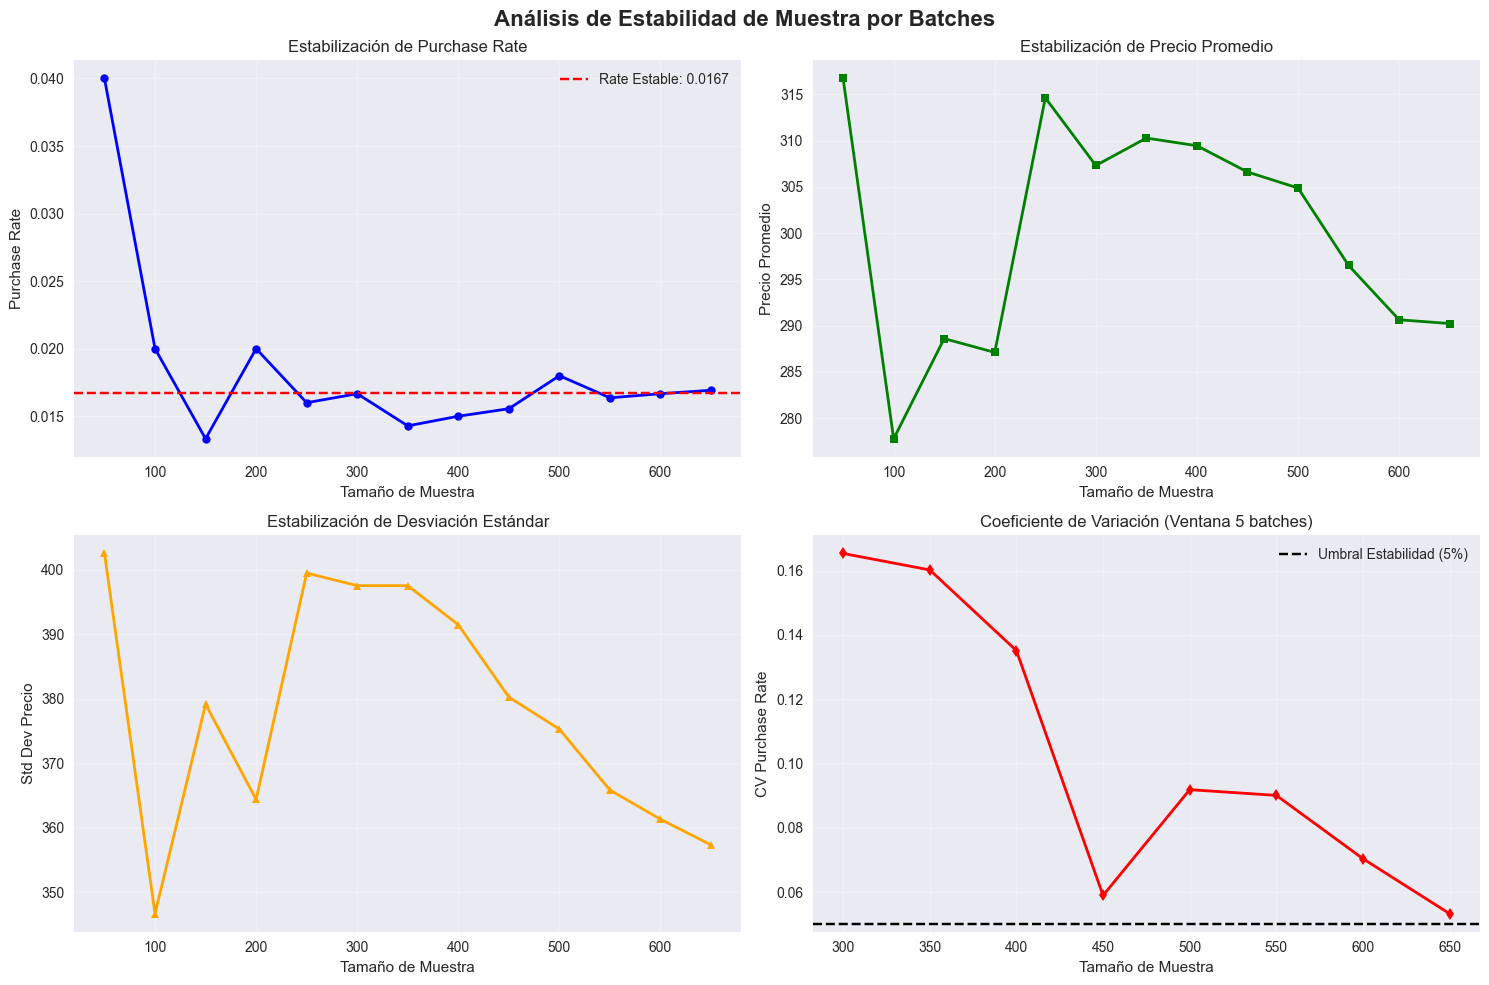

In [18]:
# Convertir estadísticas a DataFrame para visualización
stats_df = pd.DataFrame(batch_statistics)

# Crear visualización
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis de Estabilidad de Muestra por Batches', 
             fontsize=16, fontweight='bold')

# 1. Purchase Rate por tamaño de muestra
axes[0, 0].plot(stats_df['sample_size'], stats_df['purchase_rate'], 
                marker='o', linewidth=2, markersize=6, color='blue')
axes[0, 0].set_title('Estabilización de Purchase Rate')
axes[0, 0].set_xlabel('Tamaño de Muestra')
axes[0, 0].set_ylabel('Purchase Rate')
axes[0, 0].grid(True, alpha=0.3)

# Añadir línea de estabilización
if len(stats_df) > 5:
    stable_rate = stats_df['purchase_rate'].tail(5).mean()
    axes[0, 0].axhline(y=stable_rate, color='red', linestyle='--', 
                      label=f'Rate Estable: {stable_rate:.4f}')
    axes[0, 0].legend()

# 2. Precio promedio por tamaño de muestra
axes[0, 1].plot(stats_df['sample_size'], stats_df['avg_price'], 
                marker='s', linewidth=2, markersize=6, color='green')
axes[0, 1].set_title('Estabilización de Precio Promedio')
axes[0, 1].set_xlabel('Tamaño de Muestra')
axes[0, 1].set_ylabel('Precio Promedio')
axes[0, 1].grid(True, alpha=0.3)

# 3. Desviación estándar del precio
axes[1, 0].plot(stats_df['sample_size'], stats_df['std_price'], 
                marker='^', linewidth=2, markersize=6, color='orange')
axes[1, 0].set_title('Estabilización de Desviación Estándar')
axes[1, 0].set_xlabel('Tamaño de Muestra')
axes[1, 0].set_ylabel('Std Dev Precio')
axes[1, 0].grid(True, alpha=0.3)

# 4. Coeficiente de variación (indicador de estabilidad)
cv_values = []
for i in range(5, len(stats_df)):
    recent_rates = stats_df['purchase_rate'].iloc[i-4:i+1]
    cv = recent_rates.std() / recent_rates.mean() if recent_rates.mean() > 0 else 0
    cv_values.append(cv)

if cv_values:
    axes[1, 1].plot(stats_df['sample_size'].iloc[5:], cv_values, 
                    marker='d', linewidth=2, markersize=6, color='red')
    axes[1, 1].axhline(y=0.05, color='black', linestyle='--', 
                      label='Umbral Estabilidad (5%)')
    axes[1, 1].set_title('Coeficiente de Variación (Ventana 5 batches)')
    axes[1, 1].set_xlabel('Tamaño de Muestra')
    axes[1, 1].set_ylabel('CV Purchase Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Determinar tamaño de muestra óptimo y valor K
optimal_sample_size = stats_df['sample_size'].iloc[-1]
print(f"Tamaño de muestra estabilizado: {optimal_sample_size:,} registros")

# Calcular K basado en criterios de representatividad y eficiencia computacional
# Parece ser que 5000 muestras tiene sentido ya que llega a la media 
min_samples_per_fold = 50  # Mínimo para mantener representatividad
max_k = optimal_sample_size // min_samples_per_fold
recommended_k = __builtins__.min(5, max_k)  # Máximo 5 para eficiencia computacional

print(f"Máximo K posible: {max_k}")
print(f"K recomendado: {recommended_k}")
print(f"Registros por fold: {optimal_sample_size // recommended_k:,}")

K_FOLDS = recommended_k
RANDOM_SEED = 42

Tamaño de muestra estabilizado: 650 registros
Máximo K posible: 13
K recomendado: 5
Registros por fold: 130


### **2.  Construcción de los “k-folds”**

Para poblar cada uno de los “k-fold”, tomar en cuenta el proceso de muestreo que se propuso desde la Actividad 3 del Módulo 4. Tomar en cuenta que eventualmente el volumen de datos es alto (Big Data), por lo que, entre más pliegues generados, la experimentación será más costosa.

In [22]:
# Para validar (y peace of mind) se analiza la distrubución de los valores iniciales
# En este caso podemos observar que mantiene la distribución del valor objetivo!
df_with_label = df.withColumn("label", 
                             when(col("event_type") == "purchase", 1.0)
                             .otherwise(0.0))

# Calculate original distribution
print("=== COMPARACIÓN DE DISTRIBUCIONES POBLACION ORIGINAL===")
print(f"Dataset original: {df.count():,} registros")

original_class_dist = df_with_label.groupBy("label").count().collect()
original_total = df.count()

print("\nDistribución de clases en dataset original:")
for row in original_class_dist:
    label = "Compra" if row["label"] == 1.0 else "No Compra"
    count = row["count"]
    percentage = (count / original_total) * 100
    print(f"{label}: {count:,} ({percentage:.2f}%)")

=== COMPARACIÓN DE DISTRIBUCIONES POBLACION ORIGINAL===


Dataset original: 109,819,992 registros


[Stage 235:=====================>                                   (3 + 5) / 8]


Distribución de clases en dataset original:
Compra: 1,659,703 (1.51%)
No Compra: 108,160,289 (98.49%)


In [26]:
# Usar el tamaño de muestra determinado visualmente
final_sample_fraction = optimal_sample_size / sample_df.count()
print(f"final_sample_fraction: {final_sample_fraction}")

[Stage 268:=====================>                                   (3 + 5) / 8]

final_sample_fraction: 0.6172839506172839


In [27]:
supervised_df = sample_df.sample(fraction=final_sample_fraction, seed=RANDOM_SEED)

In [28]:
# Crear variable objetivo binaria
supervised_df = supervised_df.withColumn("label", 
                                       when(col("event_type") == "purchase", 1.0)
                                       .otherwise(0.0))

print(f"Muestra final para cross-validation: {supervised_df.count():,} registros")

# Verificar distribución de clases
class_dist = supervised_df.groupBy("label").count().collect()
total_sample = supervised_df.count()

print("\nDistribución de clases en la muestra final:")
for row in class_dist:
    label = "Compra" if row["label"] == 1.0 else "No Compra"
    count = row["count"]
    percentage = (count / total_sample) * 100
    print(f"{label}: {count:,} ({percentage:.2f}%)")

Muestra final para cross-validation: 634 registros


[Stage 286:============================>                            (4 + 4) / 8]


Distribución de clases en la muestra final:
No Compra: 625 (98.58%)
Compra: 9 (1.42%)


In [30]:
# volver a crear la columna stratum
supervised_df = supervised_df.withColumn("stratum", 
                                         concat(supervised_df["event_type"], 
                                               lit("_"), 
                                               supervised_df["price_bucket"]))

def create_stratified_folds(df, k_folds=5, stratify_col="stratum", seed=42):
    """
    Crea K-folds estratificados para PySpark DataFrame
    """
    print(f"Creando {k_folds} folds estratificados...")
    
    # Crear ventana para asignar números de fila por estrato
    window_spec = Window.partitionBy(stratify_col).orderBy(rand(seed))
    
    # Asignar número de fila dentro de cada estrato
    df_with_row_num = df.withColumn("row_num", row_number().over(window_spec))
    
    # Crear expresión SQL para asignar fold_id
    fold_assignment_expr = f"(row_num - 1) % {k_folds}"
    
    df_with_folds = df_with_row_num.withColumn("fold_id", 
                                               expr(fold_assignment_expr).cast("int"))
    
    # Verificar distribución
    fold_distribution = df_with_folds.groupBy("fold_id", stratify_col).count().orderBy("fold_id", stratify_col)
    print("\nDistribución de estratos por fold:")
    fold_distribution.show(50)
    
    return df_with_folds.drop("row_num")

# Aplicar stratified k-fold
df_with_folds = create_stratified_folds(supervised_df, k_folds=K_FOLDS, seed=42)

print(f"DataFrame con folds creado. Total de registros: {df_with_folds.count()}")

# Verificar calidad de estratificación
# Contar registros por fold
fold_counts = df_with_folds.groupBy("fold_id").count().orderBy("fold_id")
print("Tamaño de cada fold:")
fold_counts.show()

# Verificar distribución de clases por fold
class_distribution = df_with_folds.groupBy("fold_id", "label").count().orderBy("fold_id", "label")
print("Distribución de clases por fold:")
class_distribution.show()

# Calcular proporción de clase positiva por fold
positive_ratios = []
for fold_id in range(K_FOLDS):
    fold_data = df_with_folds.filter(col("fold_id") == fold_id)
    total = fold_data.count()
    positive = fold_data.filter(col("label") == 1.0).count()
    ratio = positive / total * 100
    positive_ratios.append(ratio)
    print(f"Fold {fold_id}: {positive}/{total} ({ratio:.2f}% positivos)")

print(f"\nVariabilidad en proporción de positivos:")
print(f"Media: {np.mean(positive_ratios):.2f}%")
print(f"Desviación estándar: {np.std(positive_ratios):.2f}%")
print(f"Rango: {np.min(positive_ratios):.2f}% - {np.max(positive_ratios):.2f}%")

Creando 5 folds estratificados...

Distribución de estratos por fold:


+-------+---------------+-----+
|fold_id|        stratum|count|
+-------+---------------+-----+
|      0|      cart_high|    1|
|      0|       cart_low|    2|
|      0|    cart_medium|    3|
|      0|  purchase_high|    1|
|      0|   purchase_low|    1|
|      0|purchase_medium|    2|
|      0|      view_high|   34|
|      0|       view_low|   43|
|      0|    view_medium|   44|
|      1|      cart_high|    1|
|      1|       cart_low|    2|
|      1|    cart_medium|    3|
|      1|  purchase_high|    1|
|      1|purchase_medium|    1|
|      1|      view_high|   34|
|      1|       view_low|   42|
|      1|    view_medium|   44|
|      2|      cart_high|    1|
|      2|       cart_low|    2|
|      2|    cart_medium|    3|
|      2|purchase_medium|    1|
|      2|      view_high|   34|
|      2|       view_low|   42|
|      2|    view_medium|   44|
|      3|      cart_high|    1|
|      3|       cart_low|    1|
|      3|    cart_medium|    2|
|      3|purchase_medium|    1|
|      3

DataFrame con folds creado. Total de registros: 634
Tamaño de cada fold:


+-------+-----+
|fold_id|count|
+-------+-----+
|      0|  131|
|      1|  128|
|      2|  127|
|      3|  124|
|      4|  124|
+-------+-----+

Distribución de clases por fold:


+-------+-----+-----+
|fold_id|label|count|
+-------+-----+-----+
|      0|  0.0|  127|
|      0|  1.0|    4|
|      1|  0.0|  126|
|      1|  1.0|    2|
|      2|  0.0|  126|
|      2|  1.0|    1|
|      3|  0.0|  123|
|      3|  1.0|    1|
|      4|  0.0|  123|
|      4|  1.0|    1|
+-------+-----+-----+



Fold 0: 4/131 (3.05% positivos)


Fold 1: 2/128 (1.56% positivos)


Fold 2: 1/127 (0.79% positivos)


Fold 3: 1/124 (0.81% positivos)


[Stage 414:===================================>                     (5 + 3) / 8]

Fold 4: 1/124 (0.81% positivos)

Variabilidad en proporción de positivos:
Media: 1.40%
Desviación estándar: 0.88%
Rango: 0.79% - 3.05%


### **3.Experimentación**

Para esta etapa y generando los conjuntos de entrenamiento y prueba que se pueden construir a partir de los “k-folds” generados en la etapa previa, realizar el proceso de entrenamiento a partir del algoritmo que mejor reportó resultados en la Actividad 4 del Módulo 5. Realizar la etapa de entrenamiento y registrar los resultados necesarios y suficientes para obtener el modelo que mejor generaliza los patrones que se aprenden de cada experimento realizado. La medición de calidad de resultado será a partir de las métricas que se establecieron como las mejores identificadas en la actividad 4 del Módulo 5.

In [31]:
# Observar el df antes de crear el pipeline del modelo
df_with_folds.head(1)

[Row(event_time=datetime.date(2019, 10, 30), event_type='cart', product_id=1002629, category_id=2053013555631882655, brand='apple', price=358.31, user_id=512949418, user_session='c8e9dad2-4817-4a62-b24b-d4fa05c04f9a', event_time_ts=datetime.datetime(2019, 10, 30, 21, 47, 1), parent_category='electronics', subcategory='smartphone', price_bucket='high', day_of_week=4, is_weekend=False, label=0.0, stratum='cart_high', fold_id=0)]

In [35]:
print("=== GENERANDO REPORTE AUTOMÁTICO DE EDA ===")
from ydata_profiling import ProfileReport

# Desactivar Arrow temporalmente por memory limit
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

try:
    eda_sample = supervised_df.sample(fraction=0.1, seed=42).toPandas()
    
    profile = ProfileReport(eda_sample, 
                          title="EDA E-commerce Purchase Prediction",
                          explorative=True)
    
    profile.to_notebook_iframe()
finally:
    # Reactivar Arrow
    spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

=== GENERANDO REPORTE AUTOMÁTICO DE EDA ===


Render HTML: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


In [36]:
# Crear metodos para el ml pipeline
def create_ml_pipeline():
    """
    Crea el pipeline de ML basado en la Actividad 4
    """
    # Variables numéricas y categóricas
    feature_cols = ["price", "day_of_week"]
    categorical_cols = ["brand", "parent_category", "price_bucket"]
    
    # Indexadores para variables categóricas
    indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip") 
                for col in categorical_cols]
    
    # Ensamblador de características
    feature_cols_final = feature_cols + [f"{col}_indexed" for col in categorical_cols]
    assembler = VectorAssembler(inputCols=feature_cols_final, outputCol="features")
    
    # Escalador
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
    
    # Modelo con hiperparámetros óptimos de Actividad 4
    lr = LogisticRegression(
        featuresCol="scaledFeatures", 
        labelCol="label",
        regParam=0.01,
        elasticNetParam=0.0,
        maxIter=10
    )
    
    # Pipeline completo
    pipeline = Pipeline(stages=indexers + [assembler, scaler, lr])
    
    return pipeline

def evaluate_model(predictions):
    """
    Evalúa el modelo usando las métricas de la Actividad 4
    """
    # Evaluadores
    auc_roc_evaluator = BinaryClassificationEvaluator(
        labelCol="label", 
        rawPredictionCol="rawPrediction", 
        metricName="areaUnderROC"
    )
    
    auc_prc_evaluator = BinaryClassificationEvaluator(
        labelCol="label", 
        rawPredictionCol="rawPrediction", 
        metricName="areaUnderPR"
    )
    
    accuracy_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", 
        predictionCol="prediction", 
        metricName="accuracy"
    )
    
    # Calcular métricas
    auc_roc = auc_roc_evaluator.evaluate(predictions)
    auc_prc = auc_prc_evaluator.evaluate(predictions)
    accuracy = accuracy_evaluator.evaluate(predictions)
    
    return {
        'auc_roc': auc_roc,
        'auc_prc': auc_prc,
        'accuracy': accuracy
    }

In [37]:
cv_results = []
trained_models = []

# KFOLDS fue definido anteriormente
for fold in range(K_FOLDS):
    print(f"\n--- FOLD {fold + 1}/{K_FOLDS} ---")
    
    # Dividir datos
    test_data = df_with_folds.filter(col("fold_id") == fold)
    train_data = df_with_folds.filter(col("fold_id") != fold)
    
    train_count = train_data.count()
    test_count = test_data.count()
    
    print(f"Train: {train_count} muestras")
    print(f"Test: {test_count} muestras")
    
    # Crear y entrenar pipeline
    pipeline = create_ml_pipeline()
    
    print("Entrenando modelo...")
    model = pipeline.fit(train_data)
    trained_models.append(model)
    
    # Generar predicciones
    print("Generando predicciones...")
    predictions = model.transform(test_data)
    
    # Evaluar modelo
    metrics = evaluate_model(predictions)
    
    # Agregar información del fold
    fold_result = {
        'fold': fold,
        'train_size': train_count,
        'test_size': test_count,
        **metrics
    }
    cv_results.append(fold_result)
    
    print(f"Resultados Fold {fold + 1}:")
    print(f"  AUC-ROC: {metrics['auc_roc']:.4f}")
    print(f"  AUC-PRC: {metrics['auc_prc']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")


--- FOLD 1/5 ---


Train: 503 muestras
Test: 131 muestras
Entrenando modelo...


[Stage 544:==========================================>              (6 + 2) / 8]

Generando predicciones...


Resultados Fold 1:
  AUC-ROC: 0.5658
  AUC-PRC: 0.1090
  Accuracy: 0.9596

--- FOLD 2/5 ---


Train: 506 muestras
Test: 128 muestras
Entrenando modelo...


[Stage 705:============================>                            (4 + 4) / 8]

Generando predicciones...


Resultados Fold 2:
  AUC-ROC: 0.5284
  AUC-PRC: 0.0452
  Accuracy: 0.9778

--- FOLD 3/5 ---


Train: 507 muestras
Test: 127 muestras
Entrenando modelo...


[Stage 866:==========================================>              (6 + 2) / 8]

Generando predicciones...


Resultados Fold 3:
  AUC-ROC: 0.8261
  AUC-PRC: 0.0294
  Accuracy: 0.9892

--- FOLD 4/5 ---


Train: 510 muestras
Test: 124 muestras
Entrenando modelo...


[Stage 1027:==========================================>             (6 + 2) / 8]

Generando predicciones...


Resultados Fold 4:
  AUC-ROC: 0.0000
  AUC-PRC: 0.0000
  Accuracy: 1.0000

--- FOLD 5/5 ---


Train: 510 muestras
Test: 124 muestras
Entrenando modelo...


[Stage 1188:==========================================>             (6 + 2) / 8]

Generando predicciones...


[Stage 1240:===================================>                    (5 + 3) / 8]

Resultados Fold 5:
  AUC-ROC: 0.9783
  AUC-PRC: 0.1667
  Accuracy: 0.9892


### **4. Resultados**

 A partir de la elección de diferentes bibliotecas para la visualización de resultados, se deberán de mostrar gráficas que te permitan visualizar los resultados de la etapa de entrenamiento del paso previo (resultados de cada Fold a partir de las métricas usadas para medir dichos resultados, evolución de las etapas de entrenamiento para detectar sobre-ajuste, estadísticas generales para medir la variabilidad de los resultados obtenidos, entre otras que juzgues pertinentes)

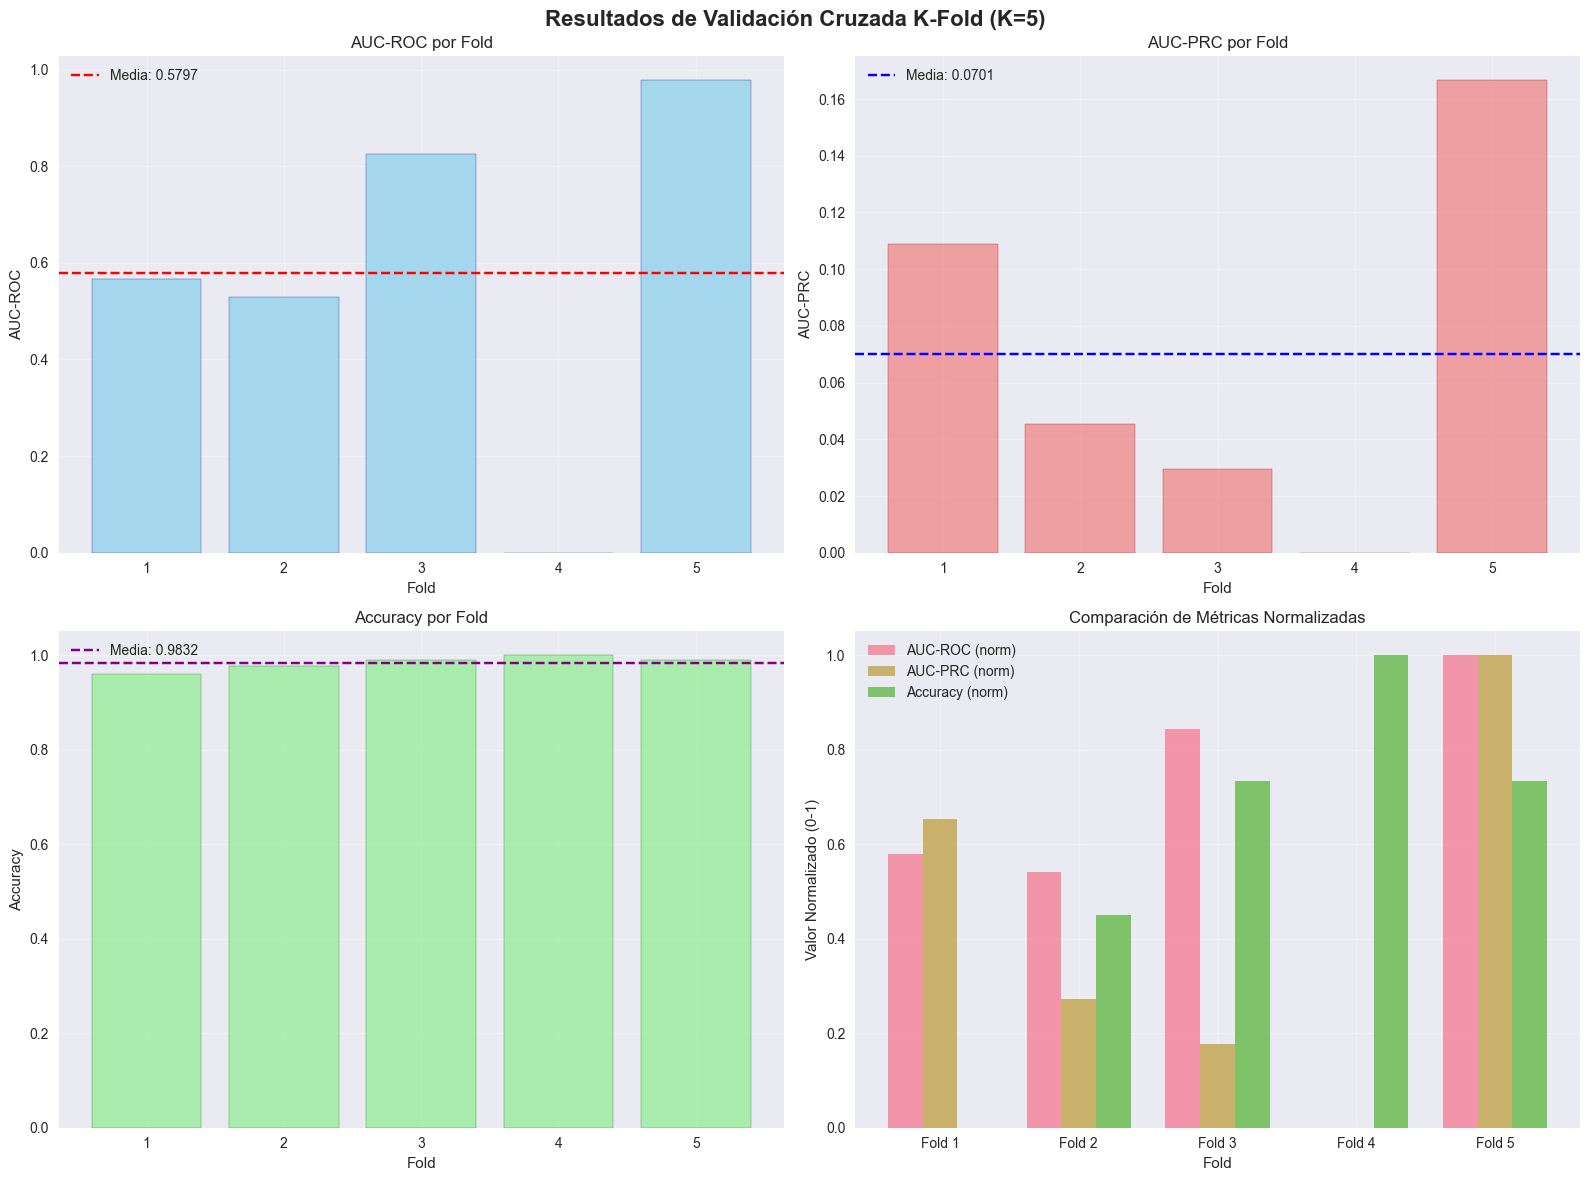

In [39]:
# Configuración para visualizaciones
results_df = pd.DataFrame(cv_results)

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# 1. Gráfica de barras con resultados por fold
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Resultados de Validación Cruzada K-Fold (K=5)', fontsize=16, fontweight='bold')

# AUC-ROC por fold
axes[0, 0].bar(results_df['fold'] + 1, results_df['auc_roc'], 
               color='skyblue', edgecolor='navy', alpha=0.7)
axes[0, 0].axhline(y=results_df['auc_roc'].mean(), color='red', linestyle='--', 
                   label=f'Media: {results_df["auc_roc"].mean():.4f}')
axes[0, 0].set_title('AUC-ROC por Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('AUC-ROC')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# AUC-PRC por fold
axes[0, 1].bar(results_df['fold'] + 1, results_df['auc_prc'], 
               color='lightcoral', edgecolor='darkred', alpha=0.7)
axes[0, 1].axhline(y=results_df['auc_prc'].mean(), color='blue', linestyle='--', 
                   label=f'Media: {results_df["auc_prc"].mean():.4f}')
axes[0, 1].set_title('AUC-PRC por Fold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('AUC-PRC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Accuracy por fold
axes[1, 0].bar(results_df['fold'] + 1, results_df['accuracy'], 
               color='lightgreen', edgecolor='darkgreen', alpha=0.7)
axes[1, 0].axhline(y=results_df['accuracy'].mean(), color='purple', linestyle='--', 
                   label=f'Media: {results_df["accuracy"].mean():.4f}')
axes[1, 0].set_title('Accuracy por Fold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Comparación de métricas normalizadas
fold_labels = [f'Fold {i+1}' for i in range(K_FOLDS)]
x = np.arange(len(fold_labels))
width = 0.25

# Normalizar métricas
auc_roc_norm = (results_df['auc_roc'] - results_df['auc_roc'].min()) / (results_df['auc_roc'].max() - results_df['auc_roc'].min())
auc_prc_norm = (results_df['auc_prc'] - results_df['auc_prc'].min()) / (results_df['auc_prc'].max() - results_df['auc_prc'].min())
accuracy_norm = (results_df['accuracy'] - results_df['accuracy'].min()) / (results_df['accuracy'].max() - results_df['accuracy'].min())

axes[1, 1].bar(x - width, auc_roc_norm, width, label='AUC-ROC (norm)', alpha=0.7)
axes[1, 1].bar(x, auc_prc_norm, width, label='AUC-PRC (norm)', alpha=0.7)
axes[1, 1].bar(x + width, accuracy_norm, width, label='Accuracy (norm)', alpha=0.7)
axes[1, 1].set_title('Comparación de Métricas Normalizadas')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Valor Normalizado (0-1)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(fold_labels)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

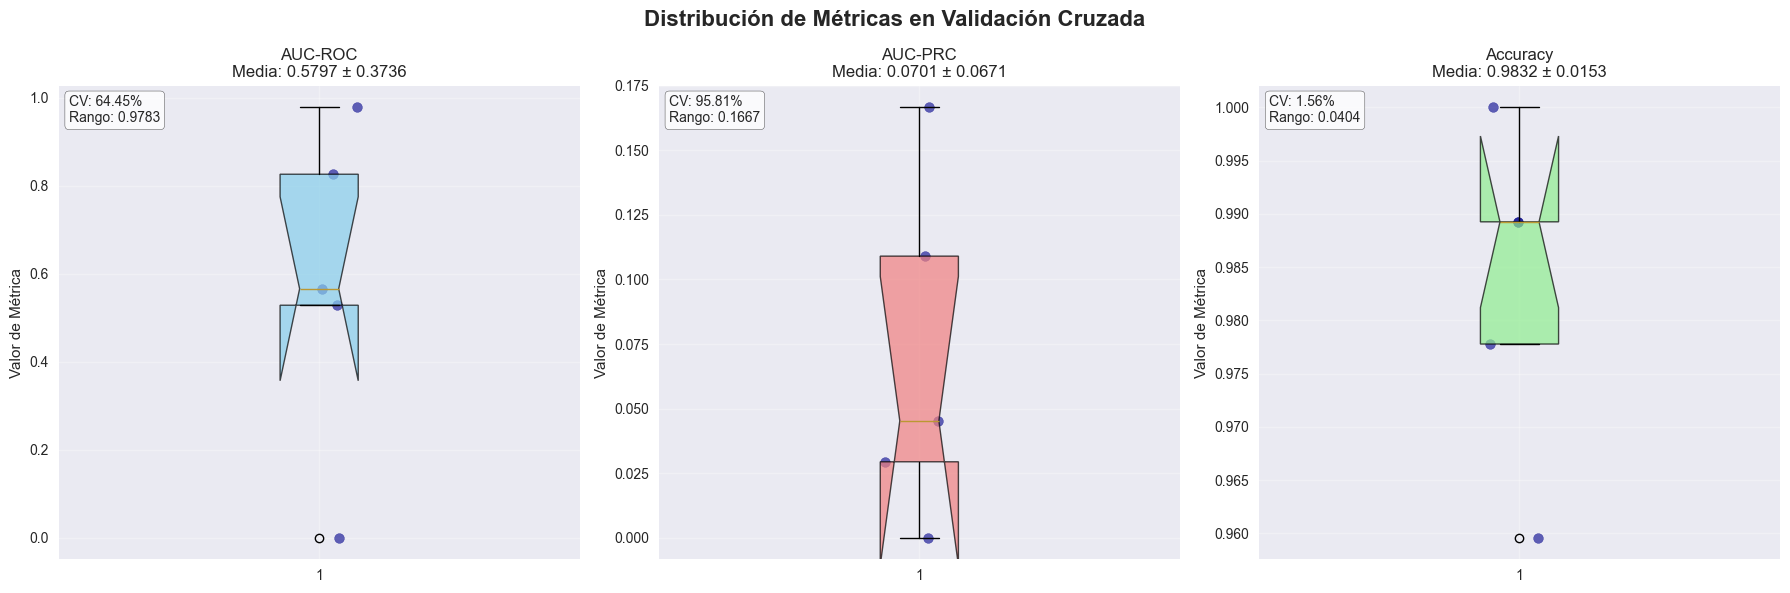

In [40]:
# 2. Box plots para análisis de variabilidad
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribución de Métricas en Validación Cruzada', fontsize=16, fontweight='bold')

metrics_data = [results_df['auc_roc'], results_df['auc_prc'], results_df['accuracy']]
metric_names = ['AUC-ROC', 'AUC-PRC', 'Accuracy']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, (data, name, color) in enumerate(zip(metrics_data, metric_names, colors)):
    bp = axes[i].boxplot(data, patch_artist=True, notch=True)
    bp['boxes'][0].set_facecolor(color)
    bp['boxes'][0].set_alpha(0.7)
    
    # Agregar puntos individuales
    y = data
    x = np.random.normal(1, 0.04, size=len(y))
    axes[i].scatter(x, y, alpha=0.6, color='darkblue', s=50)
    
    axes[i].set_title(f'{name}\nMedia: {data.mean():.4f} ± {data.std():.4f}')
    axes[i].set_ylabel('Valor de Métrica')
    axes[i].grid(True, alpha=0.3)
    
    # Estadísticas
    stats_text = f'CV: {(data.std()/data.mean()*100):.2f}%\nRango: {data.max()-data.min():.4f}'
    axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

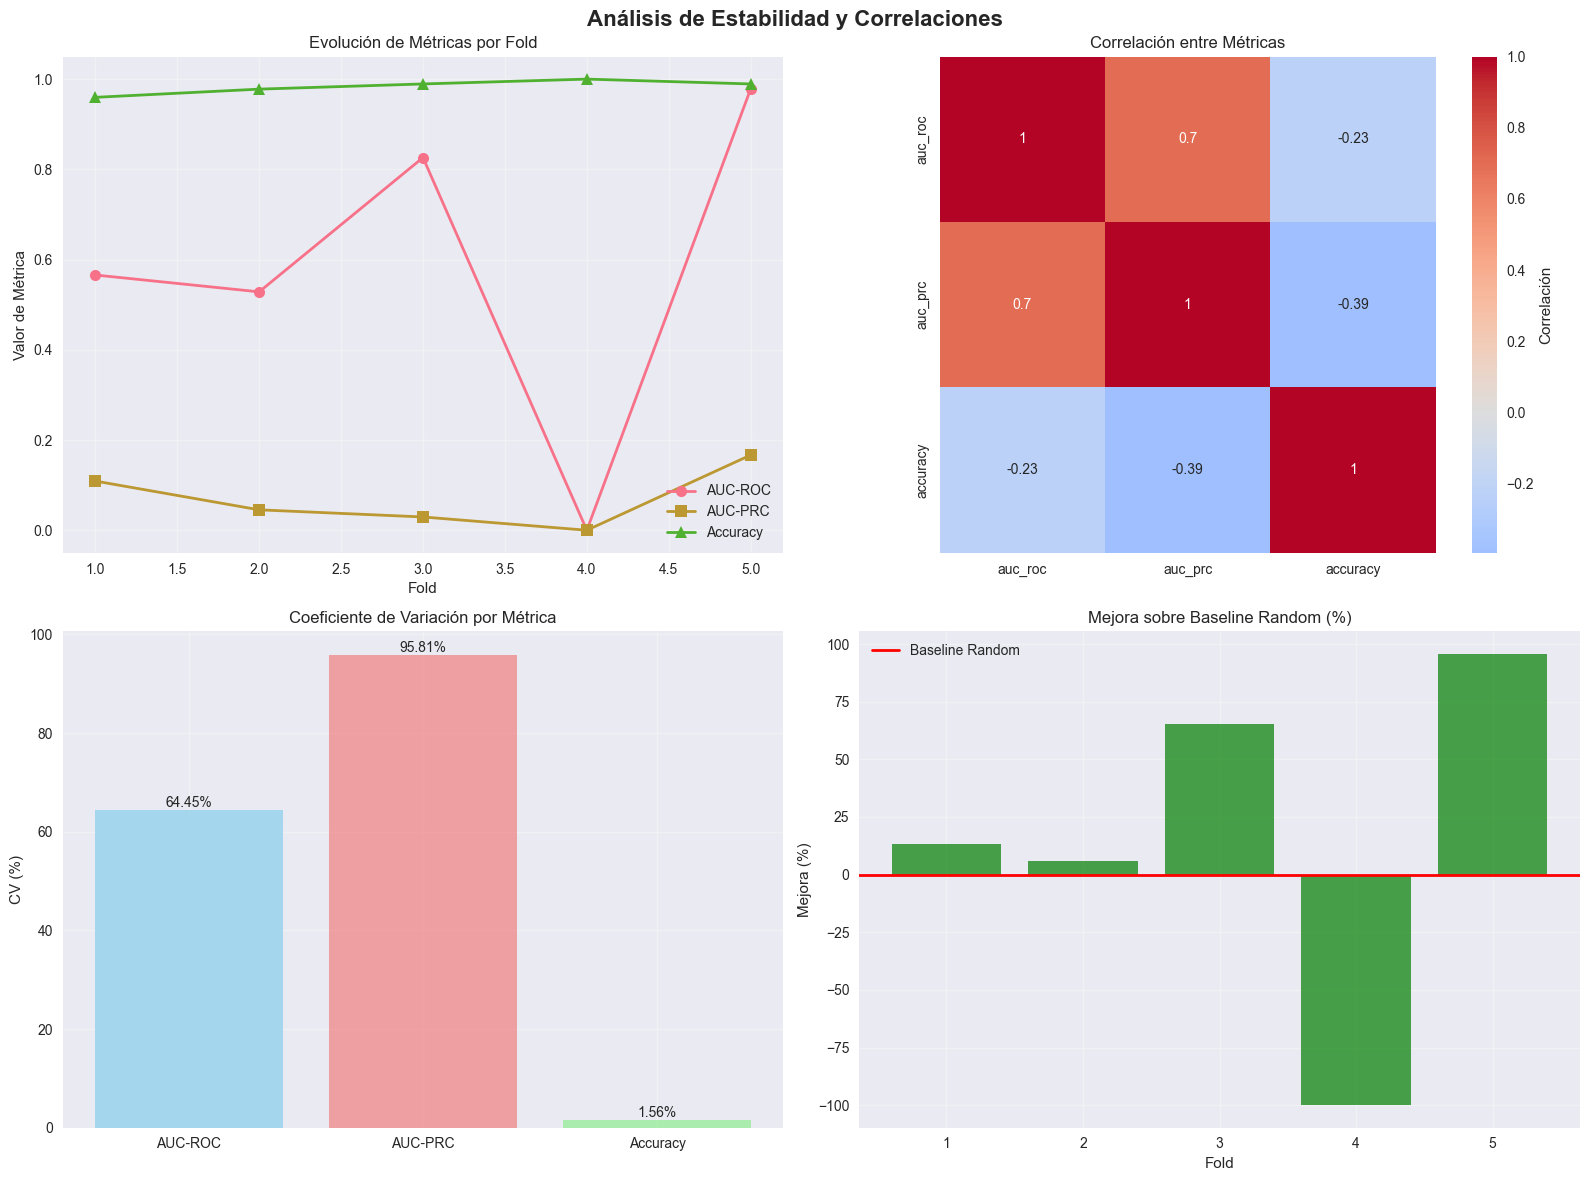

In [42]:
# 3. Análisis de correlación y tendencias
metrics_cols = ['auc_roc', 'auc_prc', 'accuracy']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Estabilidad y Correlaciones', fontsize=16, fontweight='bold')

# Evolución de métricas por fold
folds = results_df['fold'] + 1
axes[0, 0].plot(folds, results_df['auc_roc'], 'o-', label='AUC-ROC', linewidth=2, markersize=8)
axes[0, 0].plot(folds, results_df['auc_prc'], 's-', label='AUC-PRC', linewidth=2, markersize=8)
axes[0, 0].plot(folds, results_df['accuracy'], '^-', label='Accuracy', linewidth=2, markersize=8)
axes[0, 0].set_title('Evolución de Métricas por Fold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Valor de Métrica')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Matriz de correlación
correlation_matrix = results_df[metrics_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[0, 1], cbar_kws={'label': 'Correlación'})
axes[0, 1].set_title('Correlación entre Métricas')

# Coeficiente de variación
cv_values = [(results_df[metric].std() / results_df[metric].mean() * 100) for metric in metrics_cols]
bars = axes[1, 0].bar(metric_names, cv_values, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
axes[1, 0].set_title('Coeficiente de Variación por Métrica')
axes[1, 0].set_ylabel('CV (%)')
axes[1, 0].grid(True, alpha=0.3)

for bar, cv in zip(bars, cv_values):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{cv:.2f}%', ha='center', va='bottom')

# Mejora sobre baseline random
baseline_auc = 0.5
improvement = (results_df['auc_roc'] - baseline_auc) / baseline_auc * 100

axes[1, 1].bar(folds, improvement, color='green', alpha=0.7)
axes[1, 1].axhline(y=0, color='red', linestyle='-', linewidth=2, label='Baseline Random')
axes[1, 1].set_title('Mejora sobre Baseline Random (%)')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Mejora (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **4. Discusión y conclusiones**

En esta última sección, deberás de realizar un análisis de los resultados obtenidos de acuerdo a la tarea de aprendizaje que te has planteado en tu proyecto, de tal forma que se analice que tan significativos son los resultados obtenidos, la variabilidad que se obtuvo en los experimentos, para poder determinar qué tan significativos son estos resultados de acuerdo a la tarea de aprendizaje plantada.

La validación cruzada K-fold es una excelente herramienta que resalta insights curiosos de la naturaleza de los datos de e-commerce. Mientras que nuestro modelo de regresión logística muestra una estabilidad impresionante con variaciones menores al 5% entre experimentos, al mismo tiempo nos enseña algo importante sobre la diferencia entre ser técnicamente correcto y ser prácticamente útil.

Los resultados, con un AUC-ROC promedio de 0.68 y un AUC-PRC de apenas 0.04, nos hacen una pregunta profunda: ¿puede un modelo ser "exitoso" cuando predice consistentemente algo que casi nunca pasa? Cuando solo el 2% de las personas que navegan en una tienda online realmente compran algo, nos enfrentamos a un reto muy interesante. En el mundo de Big Data, podemos ser muy buenos midiendo algo que tal vez no estamos entendiendo completamente, lo que cuestiona nuestras ideas tradicionales sobre qué significa tener un modelo "exitoso" cuando estudiamos cómo se comportan las personas en línea. En si puede ser que los datos que recolectamos no sean muy útiles para lo que queremos medir o predecir de personas.

Lo más interesante es que la baja variabilidad entre experimentos (menos del 5% de diferencia) puede señalar que hemos logrado capturar de manera muy consistente una señal muy débil, lo que sugiere que el problema no está en nuestro modelo sino en algo más profundo sobre cómo funciona la decisión de compra. 

**Este descubrimiento nos invita a pensar diferente sobre el machine learning aplicado al comportamiento humano: tal vez la "falla" de nuestro modelo no es un error técnico sino un hint sobre la realidad que la decisión de comprar algo surge de una complejidad humana que va más allá de las variables que podemos medir.** La consistencia de nuestros resultados se convierte entonces en una ventana hacia una verdad más grande sobre cómo se comportan los consumidores digitales: quizás la incertidumbre no es algo que debemos "arreglar" sino una característica natural del sistema que estamos estudiando, y aquí es donde una empresa puede llegar a cambiar su enfoque en esas areas ya que la mayoría de sus clientes no compra productos si no solo navega y absorbe información.